b)	How does the tenancy status of operational holdings influence the choice of crops (cereals, pulses, vegetables, etc.) and their irrigation methods? 
a.	Rationale: This question explores the impact of land tenure on agricultural decisions, highlighting patterns in crop selection and irrigation based on ownership and leasing arrangements.
b.	Datasets Required: 
i.	Estimated Number and Area of Operational Holdings by Size Classes and Tenancy Status
ii.	Various crops datasets (Cereals, Pulses, Veg, etc.)


In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

In [35]:
df_op_holding_by_size = pd.read_csv('Estimated Number and Area of Operational Holdings by Size Classes and Tenancy Status/ZIP/7171/NDAP_REPORT_7171.csv')
df_list ={}
type_list = ['Cereal','Livestock','Oil','Fruits','Others','Forest','Pulses','Spices','Vegetables','Flower']
df_list['Cereal'] = pd.read_csv('NDAP_REPORT_7180.csv')
df_list['Flower'] = pd.read_csv('NDAP_REPORT_7179.csv')
df_list['Forest'] = pd.read_csv('NDAP_REPORT_7177.csv')
df_list['Fruits'] = pd.read_csv('NDAP_REPORT_7178.csv')
df_list['Livestock'] = pd.read_csv('NDAP_REPORT_7181.csv')
df_list['Oil'] = pd.read_csv('NDAP_REPORT_7182.csv')
df_list['Others'] = pd.read_csv('NDAP_REPORT_7183.csv')
df_list['Pulses'] = pd.read_csv('NDAP_REPORT_7175.csv')
df_list['Spices'] = pd.read_csv('NDAP_REPORT_7174.csv')
df_list['Vegetables'] = pd.read_csv('NDAP_REPORT_7176.csv')



Paddy is repeated in others as well so removing that from others DF to remove duplication of data

In [36]:
df_list['Others'] = df_list['Others'][df_list['Others']['Other type of crops'] != 'Kharif Paddy(131)']

In [37]:
irrelevant_cols_ownership = ['ROWID','YearCode', 'Year','Wholly owned and self operated holdings',
       'Wholly leased-in holdings',
       'Wholly otherwise operated holdings',
       'Partly owned and partly leased-in holdings',
       'Partly owned and partly otherwise operated holdings',
       'Partly leased-in and partly otherwise operated holdings',
       'Partly owned, partly leased-in and partly otherwise operated holdings']
df_op_holding_by_size = df_op_holding_by_size.drop(irrelevant_cols_ownership,axis=1)

In [38]:
relevant_cols_ownership = ['Area of wholly owned and self operated holdings',
       'Area of wholly leased-in holdings',
       'Area of wholly otherwise operated holdings',
       'Owned area of partly owned and partly leased-in holdings',
       'Leased area of partly owned and partly leased-in holdings',
       'Owned area of partly owned and partly otherwise operated holdings',
       'Operated area of partly owned and partly otherwise operated holdings',
       'Leased-in area of partly leased-in and partly otherwise operated holdings',
       'Operated area of partly leased-in and partly otherwise operated holdings',
       'Owned area of partly owned, partly leased-in and partly otherwise operated holdings',
       'Leased-in area of partly owned, partly leased-in and partly otherwise operated holdings',
       'Operated area of partly owned, partly leased-in and partly otherwise operated holdings',]

In [39]:
irrelevant_cols_type = ['ROWID','YearCode', 'Year','Number of holdings']
group_by_cols_type = ['Country', 'State lgd code', 'State','District lgd code','District', 'Social group type','Land area size','Category of holdings']
replacements = {'Rowid':'ROWID','Yearcode':'YearCode',' social group type':'Social group type','Irrigated area ':'Irrigated area', 'Unirrigated area ':'Unirrigated area'}
common_cols = ['Country', 'State lgd code', 'State', 'District lgd code',
       'District', 'Social group type','Land area size','Category of holdings' ]

In [40]:
merged_df = df_op_holding_by_size.drop(relevant_cols_ownership,axis=1).copy()
merged_df['Total Owned Area'] = (df_op_holding_by_size['Area of wholly owned and self operated holdings']+
                                 df_op_holding_by_size['Owned area of partly owned and partly leased-in holdings']+df_op_holding_by_size['Owned area of partly owned and partly otherwise operated holdings']+ df_op_holding_by_size['Owned area of partly owned, partly leased-in and partly otherwise operated holdings'])
merged_df['Total Leased Area'] = (df_op_holding_by_size['Area of wholly leased-in holdings']+
                                 df_op_holding_by_size['Leased area of partly owned and partly leased-in holdings']+df_op_holding_by_size['Leased-in area of partly leased-in and partly otherwise operated holdings']+ df_op_holding_by_size['Leased-in area of partly owned, partly leased-in and partly otherwise operated holdings'])
merged_df['Total Otherwise Operated Area'] = (df_op_holding_by_size['Area of wholly otherwise operated holdings']+df_op_holding_by_size['Operated area of partly owned and partly otherwise operated holdings']+df_op_holding_by_size['Operated area of partly leased-in and partly otherwise operated holdings']+ df_op_holding_by_size['Operated area of partly owned, partly leased-in and partly otherwise operated holdings'])

merged_df['Total Irrigated Area'] = merged_df['State lgd code']*0
merged_df['Total Unirrigated Area'] = merged_df['State lgd code']*0


In [41]:
for type_pro in type_list:
       col_name = f"Total area used for {type_pro}"
       # print(type_pro)
       # print(df_list[type_pro].shape)
       df_list[type_pro].rename(columns = replacements, inplace = True)
       df_list[type_pro][col_name] = df_list[type_pro]['Irrigated area'] + df_list[type_pro]['Unirrigated area'] 
       df_list[type_pro] = (df_list[type_pro].drop(df_list[type_pro].columns[11],axis=1))
       df_list[type_pro] = (df_list[type_pro].drop(irrelevant_cols_type,axis=1))
       df_list[type_pro] = df_list[type_pro].groupby(group_by_cols_type).sum().reset_index()
       merged_df = (merged_df.merge(df_list[type_pro], on=common_cols, how='left'))
       # merged_df.rename(columns = {'Irrigated area':f"Irrigated area {type_pro}"}, inplace = True)
       # merged_df.rename(columns = {'Unirrigated area':f"Unirrigated area {type_pro}"}, inplace = True)
       merged_df['Total Irrigated Area'] += merged_df['Irrigated area'].fillna(0)
       merged_df['Total Unirrigated Area'] += merged_df['Unirrigated area'].fillna(0)
       merged_df = (merged_df.drop(['Irrigated area','Unirrigated area'],axis=1))
merged_df['Total Area']=merged_df['Total Irrigated Area']+merged_df['Total Unirrigated Area']

In [42]:
merged_df = merged_df.fillna(0)

In [43]:
random = merged_df['State lgd code']
dfc = pd.DataFrame({'Total Area1':merged_df['Total Area'],'Total Area 2':(merged_df['Total Owned Area']+merged_df['Total Leased Area']+merged_df['Total Otherwise Operated Area'])})
dfc

,Total Area1,Total Area 2
0,11.198,11.900
1,21.750,21.750
2,10.250,10.250
3,25.700,25.700
4,26.050,75.350
...,...,...
29955,0.000,1843.013
29956,0.000,1169.999
29957,0.000,1432.842
29958,0.000,634.567


In [44]:
merged_df.columns

Index(['Country', 'State lgd code', 'State', 'District lgd code', 'District',
       'Social group type', 'Land area size', 'Category of holdings',
       'Total Owned Area', 'Total Leased Area',
       'Total Otherwise Operated Area', 'Total Irrigated Area',
       'Total Unirrigated Area', 'Total area used for Cereal',
       'Total area used for Livestock', 'Total area used for Oil',
       'Total area used for Fruits', 'Total area used for Others',
       'Total area used for Forest', 'Total area used for Pulses',
       'Total area used for Spices', 'Total area used for Vegetables',
       'Total area used for Flower', 'Total Area'],
      dtype='object')

In [45]:
merged_df['Category of holdings'].unique()

array(['Marginal', 'Large', 'Small', 'Semi-Medium', 'Medium'],
      dtype=object)

In [46]:
def getting_pie_values_leased(row):
       list_temp = np.zeros(10)
       temp_dict = dict.fromkeys(type_list, 0)
       if row['Total Leased Area'] == 0:
              return list_temp
       elif row['Total Area'] == 0:
              return list_temp
       else:         
              for type_name in type_list:
                     column_name = f"Total area used for {type_name}"
                     temp_dict[type_name] = (row['Total Leased Area']*(row[column_name]/row['Total Area']))
              return np.array(list(temp_dict.values()))
def getting_pie_values_owned(row):
       list_temp = np.zeros(10)
       temp_dict = dict.fromkeys(type_list, 0)
       if row['Total Owned Area'] == 0:
              return list_temp
       elif row['Total Area'] == 0:
              return list_temp
       else:         
              for type_name in type_list:
                     column_name = f"Total area used for {type_name}"
                     temp_dict[type_name] = (row['Total Owned Area']*(row[column_name]/row['Total Area']))
              return np.array(list(temp_dict.values()))
def getting_pie_values_others(row):
       list_temp = np.zeros(10)
       temp_dict = dict.fromkeys(type_list, 0)
       if row['Total Otherwise Operated Area'] == 0:
              return list_temp
       elif row['Total Area'] == 0:
              return list_temp
       else:         
              for type_name in type_list:
                     column_name = f"Total area used for {type_name}"
                     temp_dict[type_name] = (row['Total Otherwise Operated Area']*(row[column_name]/row['Total Area']))
              return np.array(list(temp_dict.values()))
              

In [47]:
merged_df[merged_df['Total Leased Area'] != 0]


,Country,State lgd code,State,District lgd code,District,Social group type,Land area size,Category of holdings,Total Owned Area,Total Leased Area,...,Total area used for Livestock,Total area used for Oil,Total area used for Fruits,Total area used for Others,Total area used for Forest,Total area used for Pulses,Total area used for Spices,Total area used for Vegetables,Total area used for Flower,Total Area
12,India,1,Jammu And Kashmir,1,Anantnag,Others,(1.0-2.0),Small,7719.473000,0.128000,...,0.000000,0.000000,1695.234000,166.381000,0.0,5.992000,0.000000,199.037000,0.000000,7632.651000
53,India,1,Jammu And Kashmir,2,Budgam,Others,(2.0-3.0),Semi-Medium,4737.345000,53.305000,...,0.000000,0.000000,709.885000,235.895000,0.0,28.844893,28.736725,123.466000,0.000000,4663.664618
90,India,1,Jammu And Kashmir,3,Baramulla,Others,(0.5-1.0),Marginal,16445.657000,25.293000,...,0.000000,0.000000,6277.121000,55.370000,0.0,178.498488,0.380877,284.300000,0.000000,16252.065365
92,India,1,Jammu And Kashmir,3,Baramulla,Others,(1.0-2.0),Small,15796.823000,17.573000,...,0.000000,0.000000,6235.137000,87.595000,0.0,110.133320,0.220342,237.429000,0.000000,15540.173663
93,India,1,Jammu And Kashmir,3,Baramulla,Others,(2.0-3.0),Semi-Medium,6862.732000,6.165000,...,0.000000,0.000000,2378.573000,24.455000,0.0,39.098107,0.221275,53.489000,0.000000,6682.137382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29809,India,36,Telangana,721,Narayanpet,Others,Below 0.5,Marginal,8997.895542,0.310131,...,100.419447,745.134812,24.962885,1154.347286,0.0,911.014561,50.918431,223.681357,4.806236,6237.636129
29810,India,36,Telangana,721,Narayanpet,Scheduled Caste,(0.5-1.0),Marginal,3901.867189,0.506382,...,63.833777,337.266798,22.222502,937.441513,0.0,463.281240,35.727237,47.927666,0.189841,3326.367642
29839,India,37,Ladakh,9,Leh Ladakh,Scheduled Tribes,Below 0.5,Marginal,2513.660000,0.290000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
29939,India,38,The Dadra And Nagar Haveli And Daman And Diu,465,Dadra And Nagar Haveli,Others,Below 0.5,Marginal,219.420000,0.172000,...,0.000000,0.000000,0.000000,0.530000,0.0,6.780000,0.000000,0.066000,0.000000,216.813000


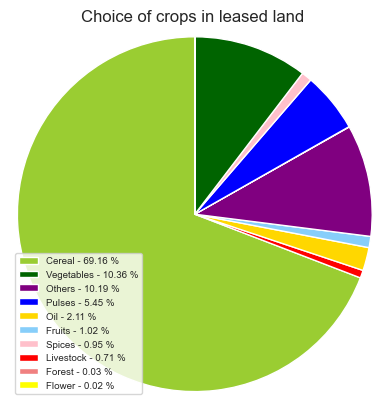

In [48]:
# leasing_df = pd.DataFrame()
leasing_df = merged_df.apply(func=getting_pie_values_leased,axis=1)
leasing_pie = np.sum(np.array(leasing_df), axis=0)
colors = ['yellowgreen','red','gold','lightskyblue','purple','lightcoral','blue','pink', 'darkgreen','yellow','grey','violet','magenta','cyan']
percent = 100.*leasing_pie/leasing_pie.sum()

patches, texts = plt.pie(leasing_pie, colors=colors, startangle=90, radius=1.2)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(type_list, percent)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, leasing_pie),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, labels, loc='lower left',
           fontsize=7)
plt.title('Choice of crops in leased land ')
plt.savefig('piechart.png', bbox_inches='tight')

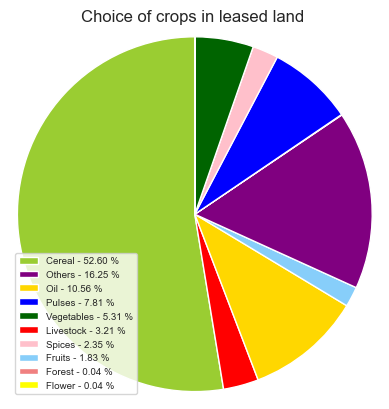

In [49]:

owning_df = merged_df.apply(func=getting_pie_values_owned,axis=1)
owning_pie = np.sum(np.array(owning_df), axis=0)
colors = ['yellowgreen','red','gold','lightskyblue','purple','lightcoral','blue','pink', 'darkgreen','yellow','grey','violet','magenta','cyan']
percent = 100.*owning_pie/owning_pie.sum()

patches, texts = plt.pie(owning_pie, colors=colors, startangle=90, radius=1.2)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(type_list, percent)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, owning_pie),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, labels, loc='lower left',
           fontsize=7)
plt.title('Choice of crops in leased land ')
plt.savefig('piechart.png', bbox_inches='tight')

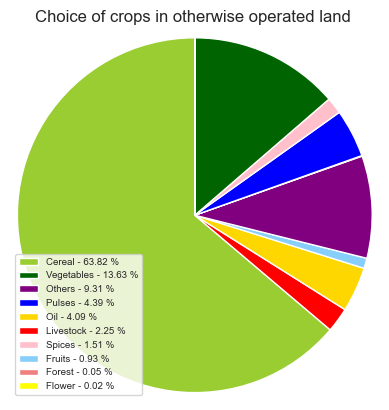

In [50]:
others_df = merged_df.apply(func=getting_pie_values_others,axis=1)
others_pie = np.sum(np.array(others_df), axis=0)
colors = ['yellowgreen','red','gold','lightskyblue','purple','lightcoral','blue','pink', 'darkgreen','yellow','grey','violet','magenta','cyan']
percent = 100.*others_pie/others_pie.sum()

patches, texts = plt.pie(others_pie, colors=colors, startangle=90, radius=1.2)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(type_list, percent)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, others_pie),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, labels, loc='lower left',
           fontsize=7)
plt.title('Choice of crops in otherwise operated land ')
plt.savefig('piechart.png', bbox_inches='tight')

In [51]:
def leased_irri_and_non_irri_group(row):
       list_temp = np.zeros(8)
       if row['Total Leased Area'] == 0:
              pass
       elif row['Total Area'] == 0:
              pass
       else:      
              #array(['Institutional', 'Others', 'Scheduled Caste', 'Scheduled Tribes'],
              irr = row['Total Leased Area']*(row['Total Irrigated Area']/row['Total Area'])
              not_irr = row['Total Leased Area']*(row['Total Unirrigated Area']/row['Total Area'])
              if row['Social group type'] == 'Scheduled Caste':
                     list_temp[0] = irr
                     list_temp[1] = not_irr
              elif row['Social group type'] == 'Scheduled Tribes':
                     list_temp[2] = irr
                     list_temp[3] = not_irr
              elif row['Social group type'] == 'Institutional':
                     list_temp[4] = irr
                     list_temp[5] = not_irr
              elif row['Social group type'] == 'Others':
                     list_temp[6] = irr
                     list_temp[7] = not_irr
       return list_temp      

def owned_irri_and_non_irri_group(row):
       list_temp = np.zeros(8)
       if row['Total Owned Area'] == 0:
              pass
       elif row['Total Area'] == 0:
              pass
       else:      
              #array(['Institutional', 'Others', 'Scheduled Caste', 'Scheduled Tribes'],
              irr = row['Total Owned Area']*(row['Total Irrigated Area']/row['Total Area'])
              not_irr = row['Total Owned Area']*(row['Total Unirrigated Area']/row['Total Area'])
              if row['Social group type'] == 'Scheduled Caste':
                     list_temp[0] = irr
                     list_temp[1] = not_irr
              elif row['Social group type'] == 'Scheduled Tribes':
                     list_temp[2] = irr
                     list_temp[3] = not_irr
              elif row['Social group type'] == 'Institutional':
                     list_temp[4] = irr
                     list_temp[5] = not_irr
              elif row['Social group type'] == 'Others':
                     list_temp[6] = irr
                     list_temp[7] = not_irr
       return list_temp      


def other_operated_irri_and_non_irri_group(row):
       list_temp = np.zeros(8)
       if row['Total Otherwise Operated Area'] == 0:
              pass
       elif row['Total Area'] == 0:
              pass
       else:      
              #array(['Institutional', 'Others', 'Scheduled Caste', 'Scheduled Tribes'],
              irr = row['Total Otherwise Operated Area']*(row['Total Irrigated Area']/row['Total Area'])
              not_irr = row['Total Otherwise Operated Area']*(row['Total Unirrigated Area']/row['Total Area'])
              if row['Social group type'] == 'Scheduled Caste':
                     list_temp[0] = irr
                     list_temp[1] = not_irr
              elif row['Social group type'] == 'Scheduled Tribes':
                     list_temp[2] = irr
                     list_temp[3] = not_irr
              elif row['Social group type'] == 'Institutional':
                     list_temp[4] = irr
                     list_temp[5] = not_irr
              elif row['Social group type'] == 'Others':
                     list_temp[6] = irr
                     list_temp[7] = not_irr
       return list_temp      
     

In [52]:
leasing_irr_group_df = merged_df.apply(func=leased_irri_and_non_irri_group,axis=1)
leasing_irr_group_bar = np.sum(np.array(leasing_irr_group_df), axis=0)
owning_irr_group_df = merged_df.apply(func=owned_irri_and_non_irri_group,axis=1)
owning_irr_group_bar = np.sum(np.array(owning_irr_group_df), axis=0)
other_operating_irr_group_df = merged_df.apply(func=other_operated_irri_and_non_irri_group,axis=1)
other_operating_irr_group_bar = np.sum(np.array(other_operating_irr_group_df), axis=0)
# print(leasing_irr_group_bar,owning_irr_group_bar,other_operating_irr_group_bar)

In [53]:

# categories = ['Irrigated_SC','Irrigated_ST','Irrigated_Others','Irrigated Institutional', 'Unirrigated']
# 
# plt.figure(figsize=(4,4))
# plt.bar(categories, owning_irr_bar, color=['skyblue', 'lightgreen'])
# 
# plt.ylabel('Area in (Ha)')
# plt.title('Owned Lands')
# plt.savefig('barplot_own.png', bbox_inches='tight')
# 
# 
# plt.figure(figsize=(4,4))
# plt.bar(categories, leasing_irr_bar, color=['skyblue', 'lightgreen'])
# 
# plt.ylabel('Area in (Ha)')
# plt.title('Leased Lands')
# plt.savefig('barplot_leas.png', bbox_inches='tight')
# 
# 
# plt.figure(figsize=(4,4))
# plt.bar(categories, other_operating_irr_bar, color=['skyblue', 'lightgreen'])
# 
# plt.ylabel('Area in (Ha)')
# plt.title('Otherwise Operated Lands')
# plt.savefig('barplot_oth.png', bbox_inches='tight')



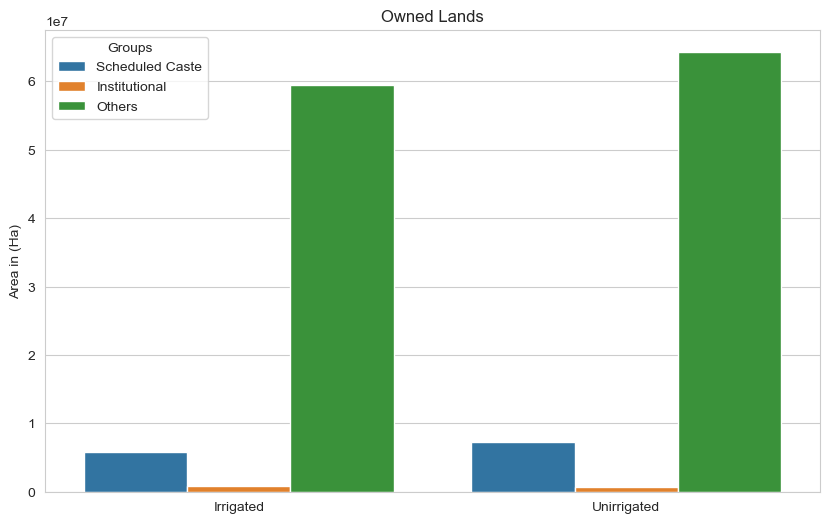

In [54]:

data = {
    'Irrigation Status': ['Irrigated', 'Unirrigated'],
    'Scheduled Caste': [owning_irr_group_bar[0],owning_irr_group_bar[1]],
    # 'Scheduled Tribe': [owning_irr_group_bar[2],owning_irr_group_bar[3]],
    'Institutional': [owning_irr_group_bar[4],owning_irr_group_bar[5]],
    'Others': [owning_irr_group_bar[6],owning_irr_group_bar[7]],    
}
df = pd.DataFrame(data)

# Melt the DataFrame to create long-form data for seaborn
df_melted = pd.melt(df, id_vars='Irrigation Status', var_name='Section', value_name='Value')

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Irrigation Status', y='Value', hue='Section')
plt.title('Owned Lands')
plt.xlabel('')
plt.ylabel('Area in (Ha)')
plt.legend(title='Groups')
plt.savefig('barplot_group_owned.png')


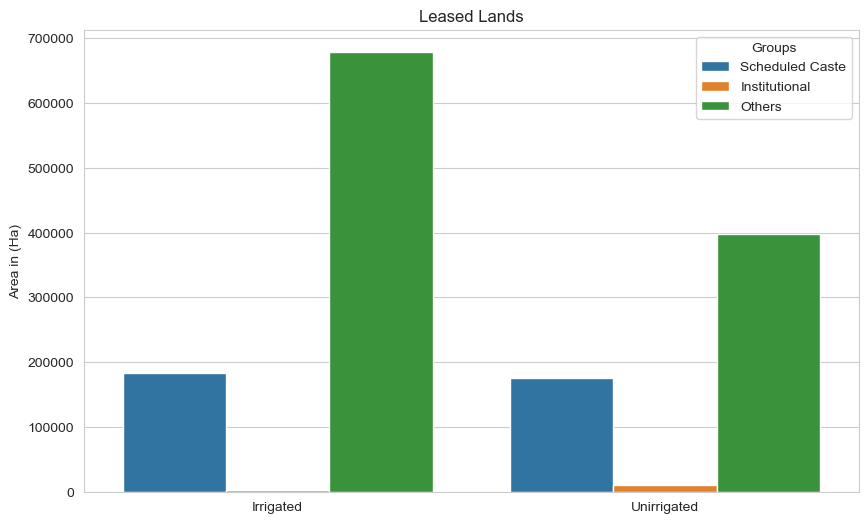

In [55]:

data = {
    'Irrigation Status': ['Irrigated', 'Unirrigated'],
    'Scheduled Caste': [leasing_irr_group_bar[0],leasing_irr_group_bar[1]],
    # 'Scheduled Tribe': [leasing_irr_group_bar[2],leasing_irr_group_bar[3]],
    'Institutional': [leasing_irr_group_bar[4],leasing_irr_group_bar[5]],
    'Others': [leasing_irr_group_bar[6],leasing_irr_group_bar[7]],
       
}
df = pd.DataFrame(data)

# Melt the DataFrame to create long-form data for seaborn
df_melted = pd.melt(df, id_vars='Irrigation Status', var_name='Section', value_name='Value')

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Irrigation Status', y='Value', hue='Section')
plt.title('Leased Lands')
plt.xlabel('')
plt.ylabel('Area in (Ha)')
plt.legend(title='Groups')
plt.savefig('barplot_group_leased.png')


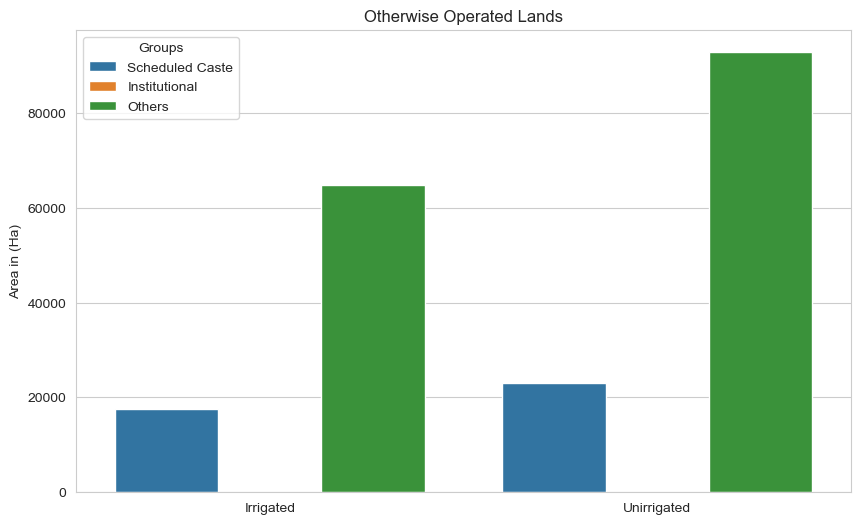

In [56]:

data = {
    'Irrigation Status': ['Irrigated', 'Unirrigated'],
    'Scheduled Caste': [other_operating_irr_group_bar[0],other_operating_irr_group_bar[1]],
    # 'Scheduled Tribe': [other_operating_irr_group_bar[2],other_operating_irr_group_bar[3]],
    'Institutional': [other_operating_irr_group_bar[4],other_operating_irr_group_bar[5]],
    'Others': [other_operating_irr_group_bar[6],other_operating_irr_group_bar[7]],    
}
df = pd.DataFrame(data)

# Melt the DataFrame to create long-form data for seaborn
df_melted = pd.melt(df, id_vars='Irrigation Status', var_name='Section', value_name='Value')

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Irrigation Status', y='Value', hue='Section')
plt.title('Otherwise Operated Lands')
plt.xlabel('')
plt.ylabel('Area in (Ha)')
plt.legend(title='Groups')
plt.savefig('barplot_group_others.png')


In [57]:
def leased_irri_and_non_irri_category(row):
       list_temp = np.zeros(10)
       if row['Total Leased Area'] == 0:
              pass
       elif row['Total Area'] == 0:
              pass
       else:      
              #array(['Institutional', 'Others', 'Scheduled Caste', 'Scheduled Tribes'],
              irr = row['Total Leased Area']*(row['Total Irrigated Area']/row['Total Area'])
              not_irr = row['Total Leased Area']*(row['Total Unirrigated Area']/row['Total Area'])
              if row['Category of holdings'] == 'Marginal':
                     list_temp[0] = irr
                     list_temp[1] = not_irr
              elif row['Category of holdings'] == 'Large':
                     list_temp[2] = irr
                     list_temp[3] = not_irr
              elif row['Category of holdings'] == 'Small':
                     list_temp[4] = irr
                     list_temp[5] = not_irr
              elif row['Category of holdings'] == 'Semi-Medium':
                     list_temp[6] = irr
                     list_temp[7] = not_irr
              elif row['Category of holdings'] == 'Medium':
                     list_temp[8] = irr
                     list_temp[9] = not_irr
       return list_temp      

def owned_irri_and_non_irri_category(row):
       list_temp = np.zeros(10)
       if row['Total Owned Area'] == 0:
              pass
       elif row['Total Area'] == 0:
              pass
       else:      
              irr = row['Total Owned Area']*(row['Total Irrigated Area']/row['Total Area'])
              not_irr = row['Total Owned Area']*(row['Total Unirrigated Area']/row['Total Area'])
              if row['Category of holdings'] == 'Marginal':
                     list_temp[0] = irr
                     list_temp[1] = not_irr
              elif row['Category of holdings'] == 'Large':
                     list_temp[2] = irr
                     list_temp[3] = not_irr
              elif row['Category of holdings'] == 'Small':
                     list_temp[4] = irr
                     list_temp[5] = not_irr
              elif row['Category of holdings'] == 'Semi-Medium':
                     list_temp[6] = irr
                     list_temp[7] = not_irr
              elif row['Category of holdings'] == 'Medium':
                     list_temp[8] = irr
                     list_temp[9] = not_irr
       return list_temp      

def other_operated_irri_and_non_irri_category(row):
       list_temp = np.zeros(10)
       if row['Total Otherwise Operated Area'] == 0:
              pass
       elif row['Total Area'] == 0:
              pass
       else:      
              irr = row['Total Otherwise Operated Area']*(row['Total Irrigated Area']/row['Total Area'])
              not_irr = row['Total Otherwise Operated Area']*(row['Total Unirrigated Area']/row['Total Area'])
              if row['Category of holdings'] == 'Marginal':
                     list_temp[0] = irr
                     list_temp[1] = not_irr
              elif row['Category of holdings'] == 'Large':
                     list_temp[2] = irr
                     list_temp[3] = not_irr
              elif row['Category of holdings'] == 'Small':
                     list_temp[4] = irr
                     list_temp[5] = not_irr
              elif row['Category of holdings'] == 'Semi-Medium':
                     list_temp[6] = irr
                     list_temp[7] = not_irr
              elif row['Category of holdings'] == 'Medium':
                     list_temp[8] = irr
                     list_temp[9] = not_irr
       return list_temp      


In [58]:
leasing_irr_category_df = merged_df.apply(func=leased_irri_and_non_irri_category,axis=1)
leasing_irr_category_bar = np.sum(np.array(leasing_irr_category_df), axis=0)
owning_irr_category_df = merged_df.apply(func=owned_irri_and_non_irri_category,axis=1)
owning_irr_category_bar = np.sum(np.array(owning_irr_category_df), axis=0)
other_operating_irr_category_df = merged_df.apply(func=other_operated_irri_and_non_irri_category,axis=1)
other_operating_irr_category_bar = np.sum(np.array(other_operating_irr_category_df), axis=0)
print(leasing_irr_category_bar,owning_irr_category_bar,other_operating_irr_category_bar)

[288042.83766938 276956.43633062 180948.06520993  46486.33279007
 170699.72147697 166966.40752303  81073.94102851  58451.73497149
 144442.93975366  35559.28224634] [17883634.91691743 15990207.10848879  5580693.15814204  7048837.06229263
 14291756.40450193 17273811.67215836 15017286.2357149  17678209.68228507
 13344248.20099182 14273204.98569188] [32911.94374979 38928.57325021  8249.92685515 11955.11414485
 15903.64266677 29878.51233323 12097.14264375 20081.11035625
 13175.57424055 15114.99775945]


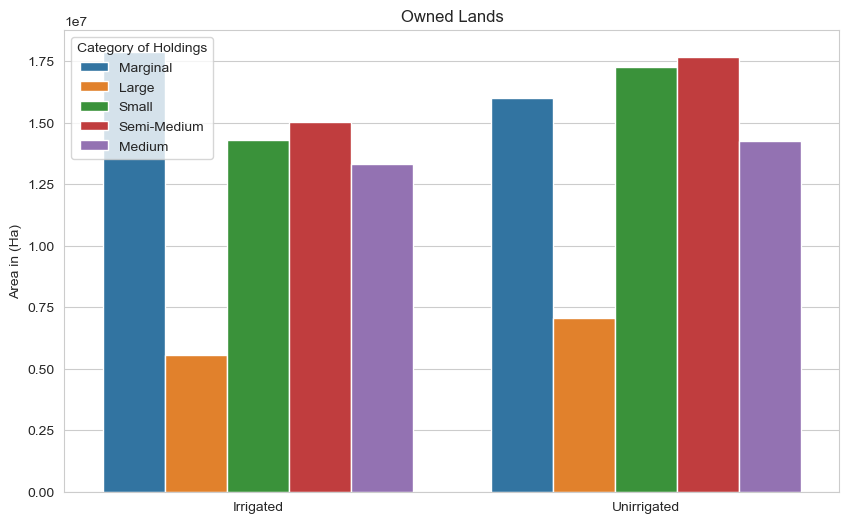

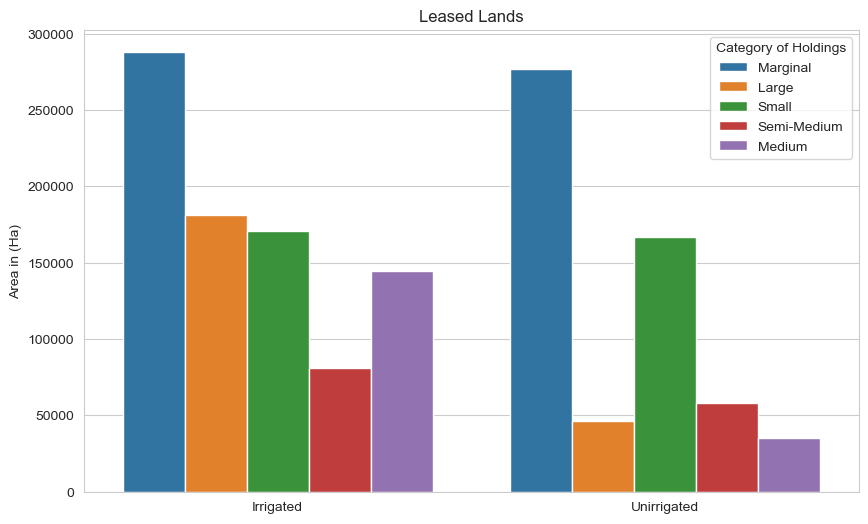

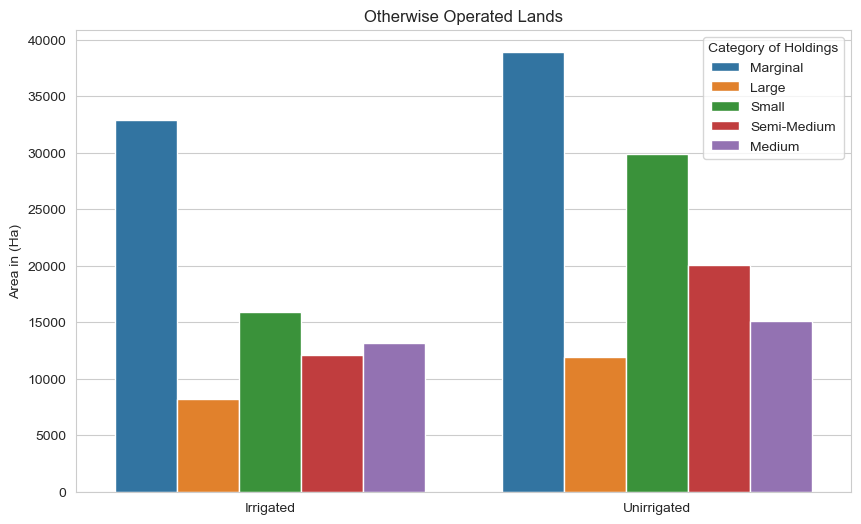

In [59]:

data = {
    'Irrigation Status': ['Irrigated', 'Unirrigated'],
    'Marginal': [owning_irr_category_bar[0],owning_irr_category_bar[1]],
    'Large': [owning_irr_category_bar[2],owning_irr_category_bar[3]],
    'Small': [owning_irr_category_bar[4],owning_irr_category_bar[5]],
    'Semi-Medium': [owning_irr_category_bar[6],owning_irr_category_bar[7]],
    'Medium': [owning_irr_category_bar[8],owning_irr_category_bar[9]],
}
df = pd.DataFrame(data)

# Melt the DataFrame to create long-form data for seaborn
df_melted = pd.melt(df, id_vars='Irrigation Status', var_name='Section', value_name='Value')

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Irrigation Status', y='Value', hue='Section')
plt.title('Owned Lands')
plt.xlabel('')
plt.ylabel('Area in (Ha)')
plt.legend(title='Category of Holdings')
plt.savefig('barplot_category_owned.png')
# plt.show()

data = {
    'Irrigation Status': ['Irrigated', 'Unirrigated'],
    'Marginal': [leasing_irr_category_bar[0],leasing_irr_category_bar[1]],
    'Large': [leasing_irr_category_bar[2],leasing_irr_category_bar[3]],
    'Small': [leasing_irr_category_bar[4],leasing_irr_category_bar[5]],
    'Semi-Medium': [leasing_irr_category_bar[6],leasing_irr_category_bar[7]],
    'Medium': [leasing_irr_category_bar[8],leasing_irr_category_bar[9]],
}
df = pd.DataFrame(data)

# Melt the DataFrame to create long-form data for seaborn
df_melted = pd.melt(df, id_vars='Irrigation Status', var_name='Section', value_name='Value')

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Irrigation Status', y='Value', hue='Section')
plt.title('Leased Lands')
plt.xlabel('')
plt.ylabel('Area in (Ha)')
plt.legend(title='Category of Holdings')
plt.savefig('barplot_category_leased.png')
# plt.show()


data = {
    'Irrigation Status': ['Irrigated', 'Unirrigated'],
    'Marginal': [other_operating_irr_category_bar[0],other_operating_irr_category_bar[1]],
    'Large': [other_operating_irr_category_bar[2],other_operating_irr_category_bar[3]],
    'Small': [other_operating_irr_category_bar[4],other_operating_irr_category_bar[5]],
    'Semi-Medium': [other_operating_irr_category_bar[6],other_operating_irr_category_bar[7]],
    'Medium': [other_operating_irr_category_bar[8],other_operating_irr_category_bar[9]],
}
df = pd.DataFrame(data)

# Melt the DataFrame to create long-form data for seaborn
df_melted = pd.melt(df, id_vars='Irrigation Status', var_name='Section', value_name='Value')

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Irrigation Status', y='Value', hue='Section')
plt.title('Otherwise Operated Lands')
plt.xlabel('')
plt.ylabel('Area in (Ha)')
plt.legend(title='Category of Holdings')
plt.savefig('barplot_category_others.png')
# plt.show()

In [60]:
merged_df['Category of holdings'].unique()

array(['Marginal', 'Large', 'Small', 'Semi-Medium', 'Medium'],
      dtype=object)

In [61]:
def pie_plot_by_category(category):
       temp_dict = dict.fromkeys(type_list,0)
       for type_pro in type_list:
              col_name = f"Total area used for {type_pro}"
              temp_dict[type_pro] = (merged_df[merged_df['Category of holdings'] == category])[col_name].sum()
       
       
       temp_pie = np.array(list(temp_dict.values()))
       colors = ['yellowgreen','red','gold','lightskyblue','purple','lightcoral','blue','pink', 'darkgreen','yellow','grey','violet','magenta','cyan']
       percent = 100.*temp_pie/temp_pie.sum()
       
       patches, texts = plt.pie(temp_pie, colors=colors, startangle=90, radius=1.2)
       labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(type_list, percent)]
       
       sort_legend = True
       if sort_legend:
           patches, labels, dummy =  zip(*sorted(zip(patches, labels, temp_pie),
                                                 key=lambda x: x[2],
                                                 reverse=True))
       
       plt.legend(patches, labels, loc='lower left',
                  fontsize=7)
       plt.title(f'Choice of crops in {category} land')
       plt.savefig(f'piechart_{category}.png', bbox_inches='tight',dpi=300)


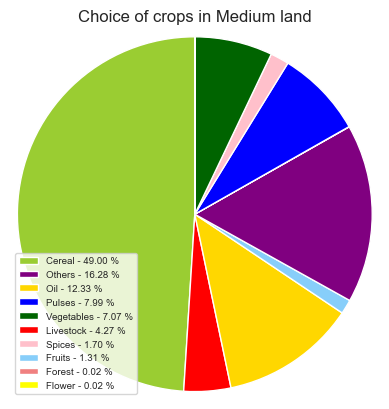

In [62]:
percentage_of_irrigation = dict.fromkeys(merged_df['Category of holdings'].unique(),0)
for category in merged_df['Category of holdings'].unique():
       pie_plot_by_category(category)
       total_irr_land = (merged_df[merged_df['Category of holdings'] == category])['Total Irrigated Area'].sum()
       total_land = (merged_df[merged_df['Category of holdings'] == category])['Total Area'].sum()
       percentage_of_irrigation[category] = (total_irr_land/total_land) * 100

In [63]:
print(percentage_of_irrigation)

{'Marginal': 57.231383621804646, 'Large': 51.47511159099901, 'Small': 49.74409179027294, 'Semi-Medium': 50.658171255241356, 'Medium': 54.05864440985964}


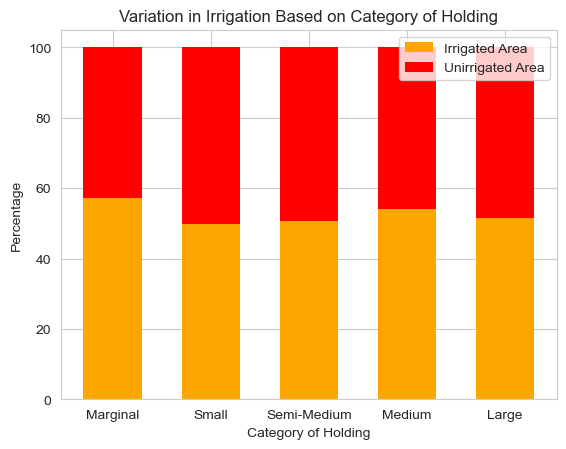

In [77]:

# Sample data
data = {
    'Category of Holding': ['Marginal','Small','Semi-Medium','Medium', 'Large'],
    'Irrigated Area': [percentage_of_irrigation['Marginal'],percentage_of_irrigation['Small'],percentage_of_irrigation['Semi-Medium'],percentage_of_irrigation['Medium'],percentage_of_irrigation['Large']],
    'Unirrigated Area': [ 100 - percentage_of_irrigation['Marginal'],100 - percentage_of_irrigation['Small'],100 - percentage_of_irrigation['Semi-Medium'],100 - percentage_of_irrigation['Medium'],100 - percentage_of_irrigation['Large']]
}

df = pd.DataFrame(data)

# Plotting the stacked bar chart
fig, ax = plt.subplots()

bar_width = 0.6

colors = ['orange', 'red']

# Stacking the bars
bottoms = np.zeros(len(df))


for idx, method in enumerate(df.columns[1:]):
    ax.bar(df['Category of Holding'], df[method], bar_width, label=method, bottom=bottoms, color=colors[idx],edgecolor='none')
    bottoms += df[method]

# Adding labels and title
ax.set_xlabel('Category of Holding')
ax.set_ylabel('Percentage')
ax.set_title('Variation in Irrigation Based on Category of Holding')
ax.legend()

plt.savefig('irr_stack.png',dpi=300)

In [99]:
high_value = ['Fruits','Spices','Vegetables','Flower']
staple_crops = ['Cereal','Pulses','Livestock']


In [100]:
def irrigated_area(crop_list):
       irr_area = 0
       non_irr_area = 0
       for crop in crop_list:
              # col_name = f"Total area used for {type_pro}"
              irr_area += df_list[crop]['Irrigated area'].sum()
              non_irr_area += df_list[crop]['Unirrigated area'].sum()
       return np.array([irr_area,non_irr_area])

In [101]:
high_value_data_irr = irrigated_area((high_value))
staple_crops_data_irr = irrigated_area(staple_crops)

In [121]:
print(high_value_data_irr)

[8799302.292 7512346.343]


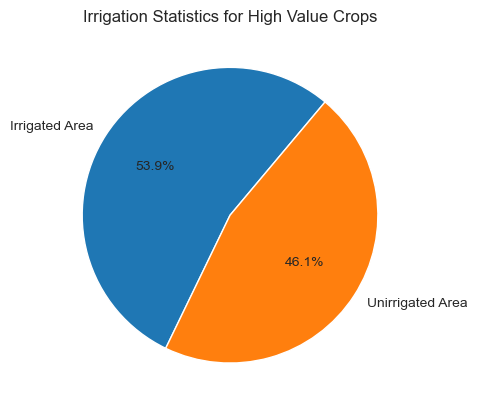

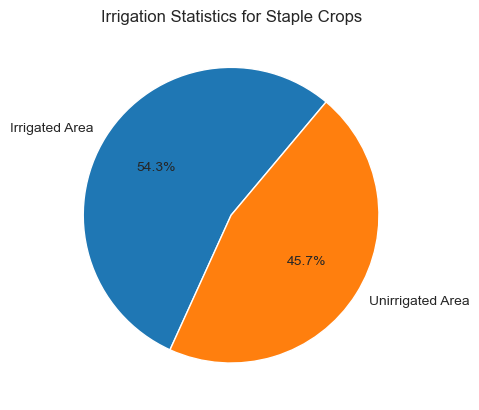

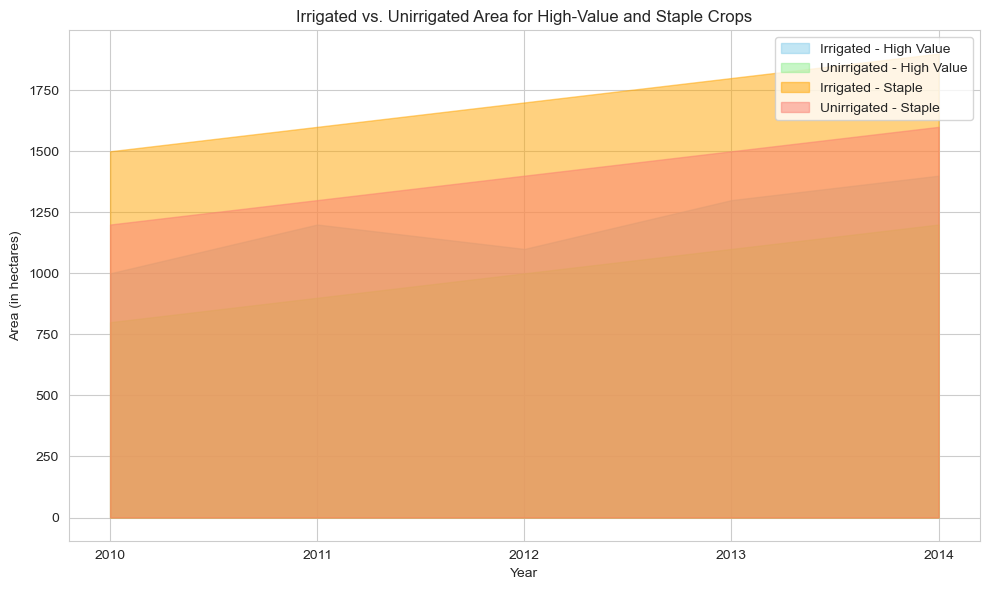

In [74]:
import matplotlib.pyplot as plt

# Sample data (replace this with your actual data)
years = [2010, 2011, 2012, 2013, 2014]
irrigated_high_value = [1000, 1200, 1100, 1300, 1400]
unirrigated_high_value = [800, 900, 1000, 1100, 1200]
irrigated_staple = [1500, 1600, 1700, 1800, 1900]
unirrigated_staple = [1200, 1300, 1400, 1500, 1600]

# Plotting the area chart
plt.figure(figsize=(10, 6))
plt.fill_between(years, irrigated_high_value, label='Irrigated - High Value', color='skyblue', alpha=0.5)
plt.fill_between(years, unirrigated_high_value, label='Unirrigated - High Value', color='lightgreen', alpha=0.5)
plt.fill_between(years, irrigated_staple, label='Irrigated - Staple', color='orange', alpha=0.5)
plt.fill_between(years, unirrigated_staple, label='Unirrigated - Staple', color='salmon', alpha=0.5)

plt.xlabel('Year')
plt.ylabel('Area (in hectares)')
plt.title('Irrigated vs. Unirrigated Area for High-Value and Staple Crops')
plt.legend()
plt.xticks(years)  # Optional: Set explicit tick marks for years
plt.tight_layout()
plt.savefig('AreaChart.png',dpi=300)


In [ ]:

# Sample data
data = {
    'Crop Type': ['Marginal','Small','Semi-Medium','Medium', 'Large'],
    'Irrigated': [percentage_of_irrigation['Marginal'],percentage_of_irrigation['Small'],percentage_of_irrigation['Semi-Medium'],percentage_of_irrigation['Medium'],percentage_of_irrigation['Large']],
    'Unirrigated Area': [ 100 - percentage_of_irrigation['Marginal'],100 - percentage_of_irrigation['Small'],100 - percentage_of_irrigation['Semi-Medium'],100 - percentage_of_irrigation['Medium'],100 - percentage_of_irrigation['Large']]
}

df = pd.DataFrame(data)

# Plotting the stacked bar chart
fig, ax = plt.subplots()

bar_width = 0.6

colors = ['orange', 'red']

# Stacking the bars
bottoms = np.zeros(len(df))


for idx, method in enumerate(df.columns[1:]):
    ax.bar(df['Category of Holding'], df[method], bar_width, label=method, bottom=bottoms, color=colors[idx],edgecolor='none')
    bottoms += df[method]

# Adding labels and title
ax.set_xlabel('Category of Holding')
ax.set_ylabel('Percentage')
ax.set_title('Variation in Irrigation Based on Category of Holding')
ax.legend()

plt.savefig('irr_stack.png',dpi=300)

In [109]:
cols_to_be_removed_irr = ['ROWID','Wholly irrigated holdings',
       'Wholly unirrigated holdings', 'Partially irrigated holdings', 'Holdings receiving irrigation',
       'Net irrigated area of holdings receiving irrigation']
irr_df_rd = pd.read_csv('NDAP_REPORT_7173.csv')
merged_df_irr = (merged_df.merge(irr_df_rd.drop(cols_to_be_removed_irr,axis=1), on=common_cols, how='left'))

In [111]:
merged_df_irr['Partially unirrigated Area'] = merged_df_irr['Area of partially irrigated holdings'] - merged_df_irr['Irrigated area of partially irrigated holdings']

Index(['Country', 'State lgd code', 'State', 'District lgd code', 'District',
       'Social group type', 'Land area size', 'Category of holdings',
       'Total Owned Area', 'Total Leased Area',
       'Total Otherwise Operated Area', 'Total Irrigated Area',
       'Total Unirrigated Area', 'Total area used for Cereal',
       'Total area used for Livestock', 'Total area used for Oil',
       'Total area used for Fruits', 'Total area used for Others',
       'Total area used for Forest', 'Total area used for Pulses',
       'Total area used for Spices', 'Total area used for Vegetables',
       'Total area used for Flower', 'Total Area', 'YearCode', 'Year',
       'Area of wholly irrigated holdings',
       'Area of wholly unirrigated holdings',
       'Irrigated area of partially irrigated holdings',
       'Area of partially irrigated holdings'],
      dtype='object')


In [122]:
merged_df_irr

,Country,State lgd code,State,District lgd code,District,Social group type,Land area size,Category of holdings,Total Owned Area,Total Leased Area,...,Total area used for Vegetables,Total area used for Flower,Total Area,YearCode,Year,Area of wholly irrigated holdings,Area of wholly unirrigated holdings,Irrigated area of partially irrigated holdings,Area of partially irrigated holdings,Partially unirrigated Area
0,India,1,Jammu And Kashmir,1,Anantnag,Institutional,(0.5-1.0),Marginal,11.900,0.0,...,0.278,0.0,11.198,2015,"Agriculture Year (Jul - Jun), 2015",10.150,0.000,0.128,1.047,0.919
1,India,1,Jammu And Kashmir,1,Anantnag,Institutional,(10.0-20.0),Large,21.750,0.0,...,0.000,0.0,21.750,2015,"Agriculture Year (Jul - Jun), 2015",21.750,0.000,0.000,0.000,0.000
2,India,1,Jammu And Kashmir,1,Anantnag,Institutional,(1.0-2.0),Small,10.250,0.0,...,0.000,0.0,10.250,2015,"Agriculture Year (Jul - Jun), 2015",10.250,0.000,0.000,0.000,0.000
3,India,1,Jammu And Kashmir,1,Anantnag,Institutional,(2.0-3.0),Semi-Medium,25.700,0.0,...,0.000,0.0,25.700,2015,"Agriculture Year (Jul - Jun), 2015",25.700,0.000,0.000,0.000,0.000
4,India,1,Jammu And Kashmir,1,Anantnag,Institutional,20 & Above,Large,75.350,0.0,...,0.000,0.0,26.050,2015,"Agriculture Year (Jul - Jun), 2015",26.050,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30195,India,38,The Dadra And Nagar Haveli And Daman And Diu,465,Dadra And Nagar Haveli,Scheduled Tribes,(3.0-4.0),Semi-Medium,1843.013,0.0,...,0.000,0.0,0.000,2015,"Agriculture Year (Jul - Jun), 2015",136.373,1395.293,93.807,138.745,44.938
30196,India,38,The Dadra And Nagar Haveli And Daman And Diu,465,Dadra And Nagar Haveli,Scheduled Tribes,(4.0-5.0),Medium,1169.999,0.0,...,0.000,0.0,0.000,2015,"Agriculture Year (Jul - Jun), 2015",99.359,933.358,49.331,65.356,16.025
30197,India,38,The Dadra And Nagar Haveli And Daman And Diu,465,Dadra And Nagar Haveli,Scheduled Tribes,(5.0-7.5),Medium,1432.842,0.0,...,0.000,0.0,0.000,2015,"Agriculture Year (Jul - Jun), 2015",90.158,1093.290,114.455,153.141,38.686
30198,India,38,The Dadra And Nagar Haveli And Daman And Diu,465,Dadra And Nagar Haveli,Scheduled Tribes,(7.5-10.0),Medium,634.567,0.0,...,0.000,0.0,0.000,2015,"Agriculture Year (Jul - Jun), 2015",40.212,480.151,34.209,45.388,11.179


In [123]:
def scale_for_each_parameter(crop_list):
       whole_irr_area = 0
       whole_unirr_area = 0
       part_irr_area = 0
       part_unirr_area = 0
       for crop in crop_list:
              col_name = f"Total area used for {crop}"
              whole_irr_area += ((merged_df_irr[col_name]*merged_df_irr['Area of wholly irrigated holdings'])/merged_df_irr['Total Area']).sum()
              whole_unirr_area += ((merged_df_irr[col_name]*merged_df_irr['Area of wholly unirrigated holdings'])/merged_df_irr['Total Area']).sum()
              part_irr_area += ((merged_df_irr[col_name]*merged_df_irr['Irrigated area of partially irrigated holdings'])/merged_df_irr['Total Area']).sum()
              part_unirr_area += ((merged_df_irr[col_name]*merged_df_irr['Partially unirrigated Area'])/merged_df_irr['Total Area']).sum()

       return [whole_irr_area,part_irr_area,whole_unirr_area,part_unirr_area]

In [178]:
high_value_data_irr_best = scale_for_each_parameter(['Vegetables'])
staple_crops_data_irr_best = scale_for_each_parameter(staple_crops)

In [179]:
print(high_value_data_irr)
print(high_value_data_irr_best)
print(staple_crops_data_irr)
print(staple_crops_data_irr_best)

[8799302.292 7512346.343]
[2212196.271035605, 697996.0485004405, 3041399.416282067, 622589.5648119303]
[71903240.254      60442780.36099999]
[36691472.61051748, 7679279.339483156, 30487179.5497101, 5304391.877309754]


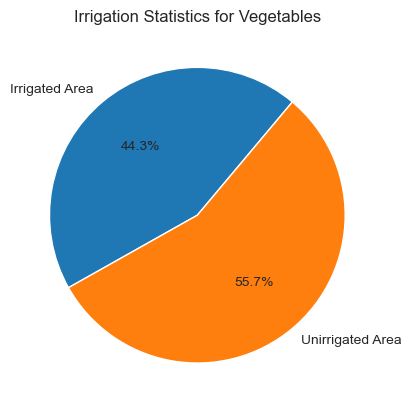

In [180]:
plt.pie([high_value_data_irr_best[0]+high_value_data_irr_best[1],high_value_data_irr_best[2]+high_value_data_irr_best[3]], labels = ['Irrigated Area','Unirrigated Area'], autopct='%1.1f%%',startangle=50)
plt.title('Irrigation Statistics for Vegetables')
plt.savefig('Vegetables.png',bbox_inches='tight',dpi=300)

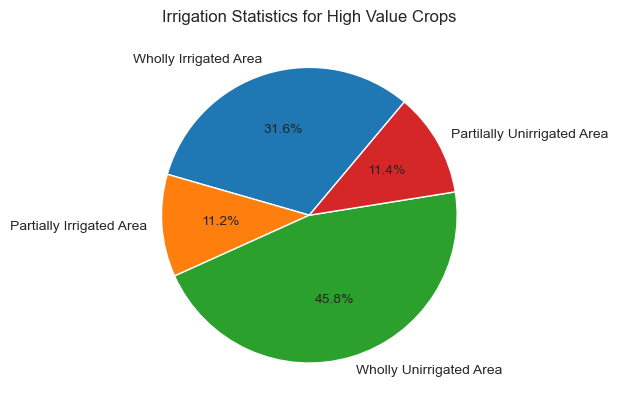

In [137]:
       plt.pie(high_value_data_irr_best, labels = ['Wholly Irrigated Area','Partially Irrigated Area','Wholly Unirrigated Area','Partilally Unirrigated Area'], autopct='%1.1f%%',startangle=50)
plt.title('Irrigation Statistics for High Value Crops')
plt.savefig('high_value_2.png',bbox_inches='tight',dpi=300)

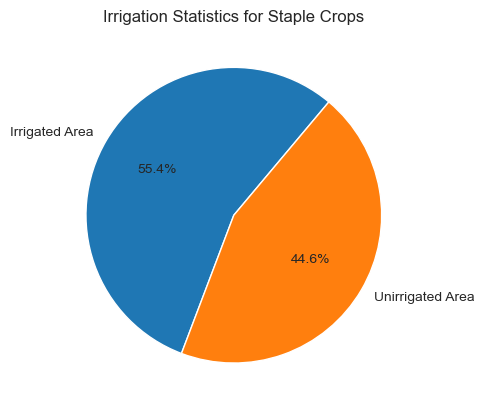

In [134]:

plt.pie([staple_crops_data_irr_best[0]+staple_crops_data_irr_best[1],staple_crops_data_irr_best[2]+staple_crops_data_irr_best[3]], labels = ['Irrigated Area','Unirrigated Area'], autopct='%1.1f%%',startangle=50)
plt.title('Irrigation Statistics for Staple Crops')
plt.savefig('staple_crops_1.png',bbox_inches='tight',dpi=300)

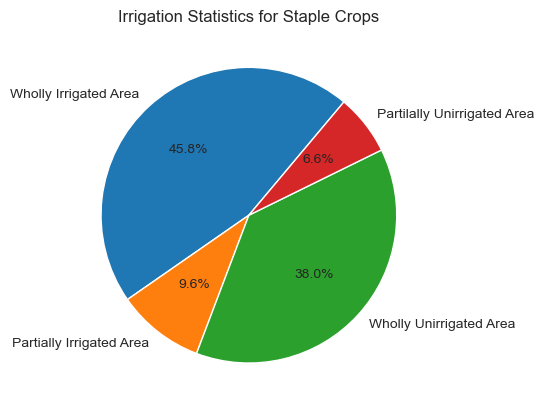

In [135]:
plt.pie(staple_crops_data_irr_best, labels = ['Wholly Irrigated Area','Partially Irrigated Area','Wholly Unirrigated Area','Partilally Unirrigated Area'], autopct='%1.1f%%',startangle=50)
plt.title('Irrigation Statistics for Staple Crops')
plt.savefig('staple_crops_2.png',bbox_inches='tight',dpi=300)